In [1]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import madrigalWeb.madrigalWeb
import re
import h5py
import numpy as np

In [2]:
#CHANGE ME
user_fullname = "Student Example"
user_email = "isr.summer.school@gmail.com"
user_affiliation = "ISR Summer School 2020"

maddat = madrigalWeb.madrigalWeb.MadrigalData('http://isr.sri.com/madrigal/')

In [3]:
#instrument codes for AMISR
instcodes={'PFISR':61,
          'RISR-N':91,
          'RISR-C':92}

In [4]:
#start time
st=datetime.datetime(2019,5,10,0,0,0)
et=datetime.datetime(2019,5,11,0,0,0)
expList = maddat.getExperiments(instcodes['PFISR'], st.year, st.month, st.day, st.hour, st.minute, st.second, et.year, et.month, et.day, et.hour, et.minute, et.second)
for exp in expList:
    print(exp)

id: 30010578
realUrl: http://isr.sri.com/madrigal/cgi-bin/madExperiment.cgi?exp=2019/pfa/09may19e&displayLevel=0&expTitle=MSWinds27.v01+-+D-region+E-region+F-region+local+measurements
url: http://isr.sri.com/madrigal/cgi-bin/madtoc/2019/pfa/09may19e
name: MSWinds27.v01 - D-region E-region F-region local measurements
siteid: 3
sitename: SRI
instcode: 61
instname: Poker Flat IS Radar
startyear: 2019
startmonth: 5
startday: 9
starthour: 22
startmin: 54
startsec: 49
endyear: 2019
endmonth: 5
endday: 10
endhour: 5
endmin: 30
endsec: 4
isLocal: True
madrigalUrl: http://isr.sri.com/madrigal
PI: unknown
PIEmail: unknown
uttimestamp: None
access: None
Madrigal version: 2.6.2

id: 30010602
realUrl: http://isr.sri.com/madrigal/cgi-bin/madExperiment.cgi?exp=2019/pfa/10may19a&displayLevel=0&expTitle=IPY27_Tracking_v03+-+Long+duration+measurements+in+support+of+the+International+Polar+Year
url: http://isr.sri.com/madrigal/cgi-bin/madtoc/2019/pfa/10may19a
name: IPY27_Tracking_v03 - Long duration meas

In [5]:
print(expList[3])

id: 30010604
realUrl: http://isr.sri.com/madrigal/cgi-bin/madExperiment.cgi?exp=2019/pfa/10may19c&displayLevel=0&expTitle=WorldDay35+-+Auroral+and+convection+measurements
url: http://isr.sri.com/madrigal/cgi-bin/madtoc/2019/pfa/10may19c
name: WorldDay35 - Auroral and convection measurements
siteid: 3
sitename: SRI
instcode: 61
instname: Poker Flat IS Radar
startyear: 2019
startmonth: 5
startday: 10
starthour: 17
startmin: 0
startsec: 47
endyear: 2019
endmonth: 5
endday: 12
endhour: 22
endmin: 6
endsec: 5
isLocal: True
madrigalUrl: http://isr.sri.com/madrigal
PI: unknown
PIEmail: unknown
uttimestamp: None
access: None
Madrigal version: 2.6.2



In [6]:
fileList = maddat.getExperimentFiles(expList[3].id)
acfile=None
for file in fileList:
    if re.match('Long Pulse',file.kindatdesc):
        acfile=file
        
filename=acfile.name
outfilename=acfile.name.split('/')[-1]
result = maddat.downloadFile(filename,outfilename, user_fullname, user_email, user_affiliation, 'hdf5')

In [7]:
with h5py.File(outfilename,'r') as f:
    PFISR_data = []
    for dat in f['Data/Array Layout'].values():
        outdct={}
        outdct['bid'] = dat['1D Parameters/beamid'][0]
        outdct['azm'] = dat['1D Parameters/azm'][0]
        outdct['elm'] = dat['1D Parameters/elm'][0]
        outdct['ne'] = 10**(dat['2D Parameters/nel'][:])
        outdct['dne'] = 10**(dat['2D Parameters/dnel'][:])
        outdct['te'] = dat['2D Parameters/te'][:]
        outdct['dte'] = dat['2D Parameters/dte'][:]
        outdct['ti'] = dat['2D Parameters/ti'][:]
        outdct['dti'] = dat['2D Parameters/dti'][:]
        outdct['vo'] = dat['2D Parameters/vo'][:]
        outdct['dvo'] = dat['2D Parameters/dvo'][:]
        
        outdct['range'] = dat['range'][:]
        outdct['altitude'] = outdct['range']*np.sin(np.radians(outdct['elm']))
        tstmp = dat['timestamps'][:]
        outdct['time'] = [datetime.datetime.utcfromtimestamp(t) for t in tstmp]
        PFISR_data.append(outdct)

In [8]:
for i,d in enumerate(PFISR_data):
    print(d['bid'],d['azm'],d['elm'])

63197.0 -35.09 66.19
63239.0 -16.23 58.68
63281.0 -2.95 47.55
63365.0 76.09 66.19
63401.0 57.23 58.68
63449.0 43.95 47.55
64016.0 14.04 90.0
64037.0 20.5 76.0
64055.0 20.5 64.0
64079.0 20.5 50.0
64157.0 -154.3 77.5


In [9]:
#find east and west beams
east=0
for i,d in enumerate(PFISR_data):
    if d['azm']==76.09:
        east=i
edat=PFISR_data[east]

west=0
for i,d in enumerate(PFISR_data):
    if d['azm']==-35.09:
        west=i
wdat=PFISR_data[west]

Text(0.5, 0.98, 'Long Pulse Data on 2019-05-11')

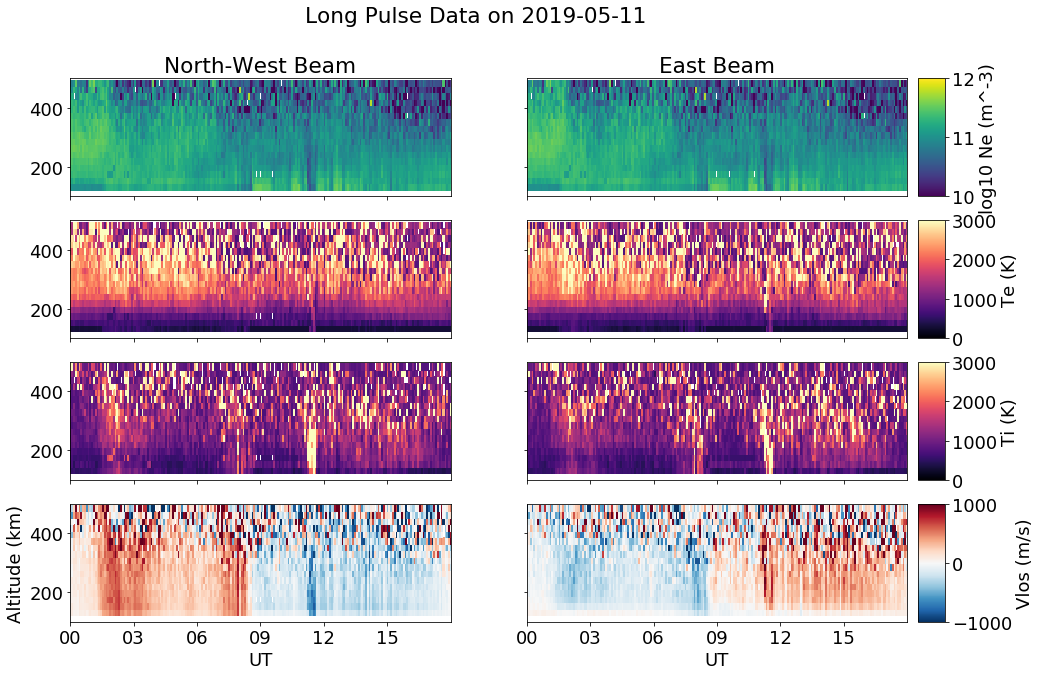

In [10]:
plt.rcParams['figure.figsize']=15,10
plt.rcParams['font.size']=18
fig,axarr=plt.subplots(4,2,sharex=True,sharey=True)

neclrs = axarr[0,0].pcolormesh(mdates.date2num(wdat['time']),wdat['altitude'],np.log10(wdat['ne']),vmin=10,vmax=12,cmap='viridis',shading='nearest')
axarr[0,0].set_ylim([100,500])

teclrs = axarr[1,0].pcolormesh(mdates.date2num(wdat['time']),wdat['altitude'],wdat['te'],vmin=0,vmax=3000,cmap='magma',shading='nearest')
axarr[1,0].set_ylim([100,500])

ticlrs = axarr[2,0].pcolormesh(mdates.date2num(wdat['time']),wdat['altitude'],wdat['ti'],vmin=0,vmax=3000,cmap='magma',shading='nearest')
axarr[2,0].set_ylim([100,500])

voclrs = axarr[3,0].pcolormesh(mdates.date2num(wdat['time']),wdat['altitude'],wdat['vo'],vmin=-1000,vmax=1000,cmap='RdBu_r',shading='nearest')
axarr[3,0].set_ylim([100,500])

axarr[0,0].set_title('North-West Beam')

neclrs = axarr[0,1].pcolormesh(mdates.date2num(wdat['time']),wdat['altitude'],np.log10(wdat['ne']),vmin=10,vmax=12,cmap='viridis',shading='nearest')
axarr[0,1].set_ylim([100,500])

teclrs = axarr[1,1].pcolormesh(mdates.date2num(edat['time']),edat['altitude'],edat['te'],vmin=0,vmax=3000,cmap='magma',shading='nearest')
axarr[1,1].set_ylim([100,500])

ticlrs = axarr[2,1].pcolormesh(mdates.date2num(edat['time']),edat['altitude'],edat['ti'],vmin=0,vmax=3000,cmap='magma',shading='nearest')
axarr[2,1].set_ylim([100,500])

voclrs = axarr[3,1].pcolormesh(mdates.date2num(edat['time']),edat['altitude'],edat['vo'],vmin=-1000,vmax=1000,cmap='RdBu_r',shading='nearest')
axarr[3,1].set_ylim([100,500])

axarr[0,1].set_title('East Beam')

axarr[-1,0].set_xlim([mdates.date2num(datetime.datetime(2019,5,11,0,0,0)),mdates.date2num(datetime.datetime(2019,5,11,18,0,0))])
axarr[-1,0].set_xticks(np.arange(mdates.date2num(datetime.datetime(2019,5,11,0,0,0)),mdates.date2num(datetime.datetime(2019,5,11,18,0,0)),3.00001/24.0))


axarr[-1,0].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
axarr[-1,0].set_xlabel('UT')
axarr[-1,1].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
axarr[-1,1].set_xlabel('UT')
axarr[-1,0].set_ylabel('Altitude (km)')
#axarr[0].set_title('Alternating Code Temperatures on 2011-08-04')


box=axarr[0,1].get_position()
necbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
necb=plt.colorbar(neclrs,cax=necbarax)
necb.set_label('log10 Ne (m^-3)')

box=axarr[1,1].get_position()
tecbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
tecb=plt.colorbar(teclrs,cax=tecbarax)
tecb.set_label('Te (K)')

box=axarr[2,1].get_position()
ticbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
ticb=plt.colorbar(ticlrs,cax=ticbarax)
ticb.set_label('Ti (K)')

box=axarr[3,1].get_position()
vocbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
vocb=plt.colorbar(voclrs,cax=vocbarax)
vocb.set_label('Vlos (m/s)')

fig.suptitle('Long Pulse Data on 2019-05-11')


# Questions

1. How are the line-of-sight velocities and ion temperatures related? What physical process causes that relationship?